In [20]:
import sys
sys.path.append('..')

# std
import numpy as np
import random as rn
import json
import time
from collections import defaultdict
from itertools import combinations
import pandas as pd
import os
import math
from matplotlib import pyplot as plt

# datasets
import STRING
import MINT
import bioGRID

# my lib
import PPILinkPred as pred
import helper as hr
import genData_helper as helper
import traversalHelper as tr

class ns:
    BRToRelat = tr.Helper.binary_to_relation
    toDualBR = tr.Helper.to_dual_binary_relation
    BRToNode = tr.Helper.binary_relation_to_node
    arr_pStr = tr.Helper.list_to_pathStrs
    pStr_arr = tr.Helper.pathStrs_to_list
    br_str = tr.Helper.br_to_pathStr

# init metadata

In [21]:
colors = {
    "L3E1_f1": "tab:blue",
    "L3E1_f2": "tab:olive",
    "L3E_f1Alt": "navy",
    "L3E_f2Alt": "gold",
    "L3": "tab:orange",
    "CN": "tab:green",
    "CRA": "tab:red",
    "CH2": "tab:brown",
    "Sim": "tab:purple",
    "rand": "tab:grey",
    "countP4": "black"
}

methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "random", "countP4", "L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]
methods_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "countP4", "L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]
abbrev_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "no.\n of $P_{4}$", "L3N'\n($f_{1}$)", "L3N'\n($f_{2}$)", "L3N\n($f_{1}$)", "L3N\n($f_{2}$)"]
label_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "no. of $P_{4}$", "L3N'($f_{1}$)", "L3N'($f_{2}$)", "L3N($f_{1}$)", "L3N($f_{2}$)"]

methods_names = dict(zip(methods, methods_map))
methods_names_inv = dict(zip(methods_map, methods))
abbrevs = dict(zip(methods_map, abbrev_map))
labels = dict(zip(methods_map, label_map))

# parse data

1. analyze overlaps with existing database
2. analyze overlaps with top n PPIs (out of top n PPIs)

In [22]:
# get uniprot mapping, because datasets are gene based
human_map_f = ".././data/UniProt/uniprot-filtered-organism__Homo+sapiens+(Human)+[9606]_.tab"
yeast_map_f = ".././data/UniProt/uniprot-organism__Saccharomyces+cerevisiae+(strain+ATCC+204508+_+S288c%2--.tab"
yeast_map, human_map = {}, {} # {gene name: uniprot ID}

def parse_map(f):
    df = pd.read_csv(f, sep='\t')
    # use first gene in gene names if primary gene not available, if still no, drop
    missingGeneRows = np.where(pd.isnull(df))[0]
    for i in missingGeneRows:
        if df.iloc[i]['Gene names'] is np.nan: continue
        df.iloc[i]['Gene names  (primary )'] = df.iloc[i]['Gene names'].split(" ")[0]
    df.dropna(inplace=True)
    df.drop('Gene names', axis=1, inplace=True)
    # if multiple primary gene name (split by ;, duplicate entries)
    tmp_df = df[df['Gene names  (primary )'].str.contains('; ')]
    dup_df = defaultdict(list)
    for i in tmp_df.index:
        dup_entries = tmp_df.loc[i]['Gene names  (primary )'].split('; ')
        for dup in dup_entries:
            dup_df['Entry'].append(tmp_df.loc[i]['Entry'])
            dup_df['Entry name'].append(tmp_df.loc[i]['Entry name'])
            dup_df['Gene names  (primary )'].append(dup)
    dup_df = pd.DataFrame(dup_df)
    df = pd.concat([df, dup_df])
    df.reset_index(inplace=True)
    return dict(zip(df['Gene names  (primary )'], df['Entry']))

yeast_map = parse_map(yeast_map_f)
human_map = parse_map(human_map_f)
combine_map = {}
combine_map.update(yeast_map)
combine_map.update(human_map)

print(list(combine_map.keys())[:10])
print(list(combine_map.values())[:10])

['OLI1', 'BRE1', 'BUR2', 'CBF2', 'CEP3', 'IMP4', 'LCB5', 'LAG1', 'PFK1', 'PTC5']
['P61829', 'Q07457', 'Q05949', 'P32504', 'P40969', 'E7ENR5', 'Q06147', 'P38703', 'P16861', 'Q12511']


In [39]:
# read negatome
negatome_dir = ".././data/negatome/"
strict_negat_f = "combined_stringent (uniprot ID).txt"
full_negat_f = "combined (uniprot ID).txt"

strict_df = pd.read_csv(negatome_dir+strict_negat_f, sep='\t', header=None)
full_df = pd.read_csv(negatome_dir+full_negat_f, sep='\t', header=None)
# convert ppi into string for matching
strict_negat_ppis = set(tr.Helper.list_to_pathStrs(
    list(np.transpose(np.asarray(
    [strict_df[0], strict_df[1]])))
    + list(np.transpose(np.asarray(
    [strict_df[1], strict_df[0]])))
))
full_negat_ppis = set(tr.Helper.list_to_pathStrs(
    list(np.transpose(np.asarray(
    [full_df[0], full_df[1]])))
    + list(np.transpose(np.asarray(
    [full_df[1], full_df[0]])))
))
print(list(strict_negat_ppis)[:10])
print(len(full_negat_ppis)/2)

['Q8RQE7\tQ72I32', 'B8YB59\tQ980A3', 'P05737\tP0CX41', 'Q8TAK5\tQ16254', 'Q8BP92\tQ99J85', 'O60674\tO14543', 'P56279\tO15530', 'P33672\tQ3MHN0', 'P61769\tQ8IJ44', 'P05627\tQ61768']
5827.0


# analysis (yeast)

1. check valid ppis from predicted ppis (how many uniprot paired) (use validPPIsStats above make table)
2. check ratio of negat ppis (by shifting and getting negat ppis hit)

In [41]:
# parse predicted PPIs
# parse ppi of different predictor & ds into one data structure
methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2", "random"]
ds_names = ['bioGRID', 'STRING', 'MINT']
ds_names = ["{}_contam{}Percent".format(i, j) for i in ds_names for j in range(5,26,5)]

validPPIsStats = {}
topPPIs = {}
for randSz in range(50, 51, 10):
    topPPIs[randSz] = defaultdict(dict)
    validPPIsStats[randSz] = defaultdict(dict)
    for method in methods:
        for ds in ds_names:
            if randSz == 50:
                filename = "./linkPred_out_reduced/{}_{}_topPPI.json".format(method, ds)
            else:
                filename = "./linkPred_out_reduced/{}_{}_randSz{}_topPPI.json".format(method, ds, randSz)
            with open(filename, "r") as f:
                tmpPPIs = json.loads(f.read())
                topPPIs[randSz][method][ds] = []
                validPPIsStats[randSz][method][ds] = []
                for trial in range(len(tmpPPIs)):
                    topPPIs[randSz][method][ds].append([
                        combine_map[i[0]]+"\t"+combine_map[i[1]] for i in tmpPPIs[trial] if i[0] in combine_map and i[1] in combine_map
                    ])
                    validPPIsStats[randSz][method][ds].append(
                        [len(topPPIs[randSz][method][ds][-1]), len(tmpPPIs[trial])])
            
# structure: topPPIs = {'commonNeighbor': ['bioGRID': [[ppi1, ppi2], ...], ...], ...}
# ppi string format is uniprot
print(topPPIs[50]['commonNeighbor']['bioGRID_contam5Percent'][0][0:10])
print(len(topPPIs[50]['commonNeighbor']['bioGRID_contam5Percent'][0]))
print("paired: "+str(validPPIsStats[50]['commonNeighbor']['bioGRID_contam5Percent'][0][0]
            )+", original: "+str(validPPIsStats[50]['commonNeighbor']['bioGRID_contam5Percent'][0][1]))

['Q15742\tP39517', 'P39517\tQ07807', 'Q15742\tA0N0Q1', 'P39016\tP39517', 'A0N0Q1\tP38144', 'P39016\tA0N0Q1', 'P39517\tP38144', 'P40150\tA0N0Q1', 'P40150\tQ15742', 'P38934\tP39517']
56260
paired: 56260, original: 56557


In [42]:
allPPIs = []
for method in methods:
    for ds in ds_names:  
        for trial in range(len(topPPIs[50][method][ds])):
            for ppi in topPPIs[50][method][ds][trial]:
                allPPIs.append(ppi)
allPPIs = set(allPPIs)
print(len(allPPIs), len(full_negat_ppis), len(allPPIs&full_negat_ppis))

6611433 11654 1488


In [25]:
fullNegPPI_hits = defaultdict(dict)
for method in methods:
    for ds in ds_names:
        fullNegPPI_hits[method][ds] = []    
        for trial in range(len(topPPIs[50][method][ds])):
            fullNegPPI_hits[method][ds].append([])
            fullCount, strictCount = 0, 0
            for ppi in topPPIs[50][method][ds][trial]:
                if ppi in full_negat_ppis: fullCount += 1
                fullNegPPI_hits[method][ds][-1].append(fullCount)

In [37]:
negPPICount = defaultdict(dict)
for method in methods:
    for ds in ds_names:
        negPPICount[ds][methods_names[method]] = []
        for trial in range(len(fullNegPPI_hits[method][ds])):
            negPPICount[ds][methods_names[method]].append(fullNegPPI_hits[method][ds][trial][-1])

C:\Users\andy8\AppData\Local\Temp/ipykernel_40244/4098830592.py:52: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


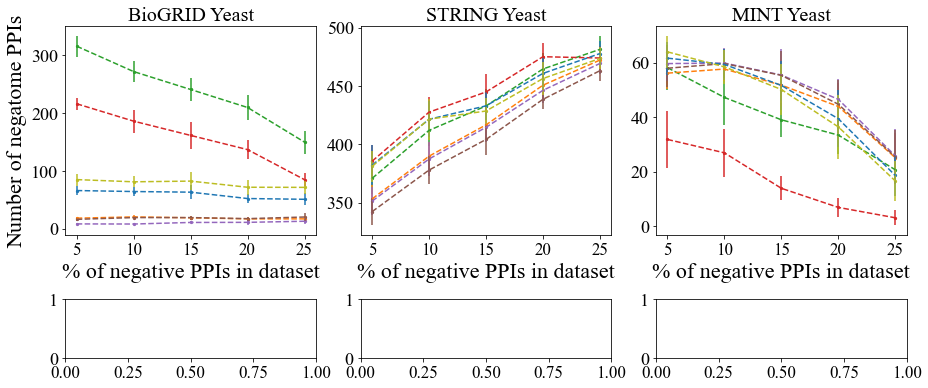

In [35]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

# lineAxes
dss = ['bioGRID', 'STRING', 'MINT']
dsNames = ['BioGRID', 'STRING', 'MINT']
titles = ['BioGRID Yeast', 'STRING Yeast', 'MINT Yeast']
fig = plt.figure(constrained_layout=True, figsize=(13, 5.5))
widths = [1,1,1]
heights = [6,1.7]
spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]
for i in range(len(dss)):
    ds = dss[i]
    ax = lineAxes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
        ax.errorbar([contamSz for contamSz in range(5, 26, 5)]
                    , [np.mean(negPPICount["{}_contam{}Percent".format(ds, contam)][method]) for contam in range(5, 26, 5)],
                    fmt='--', color=colors[method],
                    yerr=np.transpose(np.asarray(
                        [np.std(negPPICount["{}_contam{}Percent".format(ds, contam)][method]) for contam in range(5, 26, 5)]
                    )))
        ax.scatter([contamSz for contamSz in range(5, 26, 5)],
                   [np.mean(negPPICount["{}_contam{}Percent".format(ds, contam)][method]) for contam in range(5, 26, 5)],
                   s=5, color=colors[method])
        ax.set_xlabel("% of negative PPIs in dataset")
        ax.set_xticks([contamSz for contamSz in range(5, 26, 5)])
    #ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_title(titles[i])
lineAxes[0].set_ylabel("Number of negatome PPIs")


# barAxes
'''
for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]

    xtick = [k for k in list(sorted_mean_auc[ds])]
    ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[ds][x] for x in xtick]
                      , yerr=[err_auc[ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)
barAxes[0].set_ylabel("AUC")
'''
plt.tight_layout()
plt.savefig("./img_experiments/L3E_negatome_yeast.png", dpi=300)
plt.show()

C:\Users\andy8\AppData\Local\Temp/ipykernel_10824/511916963.py:54: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


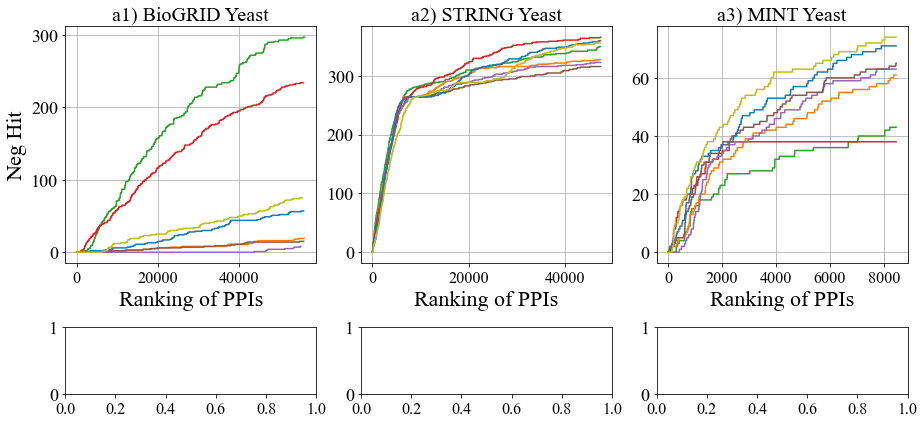

In [127]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

# lineAxes
dss = ['bioGRID', 'STRING', 'MINT']
dsNames = ['BioGRID', 'STRING', 'MINT']
randSz = 50
fig = plt.figure(constrained_layout=True, figsize=(13, 6))
widths = [1,1,1]
heights = [6,1.7]
spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]
for i in range(len(dss)):
    ds = dss[i]
    ax = lineAxes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
        '''
        ax.fill_between(precRec[randSz][ds][method]['baseRec']
                , precRec[randSz][ds][method]['lowerPrec']
                , precRec[randSz][ds][method]['upperPrec']
                , facecolor=colors[method], color=colors[method]
                , alpha=0.3)
        '''
        ax.plot([i for i in range(len(fullNegPPI_hits[methods_names_inv[method]][ds][0]))]
                , fullNegPPI_hits[methods_names_inv[method]][ds][0]
                , color=colors[method], label=method)

    ax.set_xlabel("Ranking of PPIs")
    ax.set_title("a{}) {} Yeast".format(i+1, dsNames[i]))
    ax.grid()
lineAxes[0].set_ylabel("Neg Hit")


# barAxes
'''
for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]

    xtick = [k for k in list(sorted_mean_auc[randSz][ds]) if k != 'rand']
    ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                      , yerr=[err_auc[randSz][ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)
barAxes[0].set_ylabel("PR AUC")
'''

plt.tight_layout()
plt.show()

# analysis (human)

In [38]:
# parse predicted PPIs
# parse ppi of different predictor & ds into one data structure
methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2", "random"]
ds_names = ['bioGRID_human', 'STRING_human', 'MINT_human', 'HuRI']

validPPIsStats = {}
topPPIs = {}
for randSz in range(50, 51, 10):
    topPPIs[randSz] = defaultdict(dict)
    validPPIsStats[randSz] = defaultdict(dict)
    for method in methods:
        for ds in ds_names:
            if randSz == 50:
                filename = "./linkPred_out_reduced/{}_{}_topPPI.json".format(method, ds)
            else:
                filename = "./linkPred_out_reduced/{}_{}_randSz{}_topPPI.json".format(method, ds, randSz)
            with open(filename, "r") as f:
                tmpPPIs = json.loads(f.read())
                topPPIs[randSz][method][ds] = []
                validPPIsStats[randSz][method][ds] = []
                for trial in range(len(tmpPPIs)):
                    topPPIs[randSz][method][ds].append([
                        combine_map[i[0]]+"\t"+combine_map[i[1]] for i in tmpPPIs[trial] if i[0] in combine_map and i[1] in combine_map
                    ])
                    validPPIsStats[randSz][method][ds].append(
                        [len(topPPIs[randSz][method][ds][-1]), len(tmpPPIs[trial])])
            
# structure: topPPIs = {'commonNeighbor': ['bioGRID': [[ppi1, ppi2], ...], ...], ...}
# ppi string format is uniprot
print(topPPIs[50]['commonNeighbor']['bioGRID_human'][0][0:10])
print(len(topPPIs[50]['commonNeighbor']['bioGRID_human'][0]))
print("paired: "+str(validPPIsStats[50]['commonNeighbor']['bioGRID_human'][0][0]
            )+", original: "+str(validPPIsStats[50]['commonNeighbor']['bioGRID_human'][0][1]))

['M0QXJ3\tB3CJ92', 'M0QXJ3\tA0A348FV94', 'A0A348FV94\tM0QXJ3', 'A0A348FV94\tM0QXJ3', 'J3KP20\tB3CJ92', 'M0QXJ3\tC9JMI6', 'H0YCJ5\tM0QXJ3', 'H0YCJ5\tM0QXJ3', 'A0A348FV94\tJ3KP20', 'A0A348FV94\tB3CJ92']
201749
paired: 201749, original: 226342


In [40]:
allPPIs = []
for method in methods:
    for ds in ds_names:  
        for trial in range(len(topPPIs[50][method][ds])):
            for ppi in topPPIs[50][method][ds][trial]:
                allPPIs.append(ppi)
allPPIs = set(allPPIs)
print(len(allPPIs), len(full_negat_ppis), len(allPPIs&full_negat_ppis))

5712767 11654 9


In [145]:
strictNegPPI_hits = defaultdict(dict)
fullNegPPI_hits = defaultdict(dict)
for method in methods:
    for ds in ds_names:
        strictNegPPI_hits[method][ds] = []
        fullNegPPI_hits[method][ds] = []    
        for trial in range(len(topPPIs[50][method][ds])):
            fullNegPPI_hits[method][ds].append([])
            strictNegPPI_hits[method][ds].append([])            
            fullCount, strictCount = 0, 0
            for ppi in topPPIs[50][method][ds][trial]:
                if ppi in strict_negat_ppis: strictCount += 1
                if ppi in full_negat_ppis: fullCount += 1
                fullNegPPI_hits[method][ds][-1].append(fullCount)
                strictNegPPI_hits[method][ds][-1].append(strictCount)

bioGRID_human
STRING_human
MINT_human
HuRI


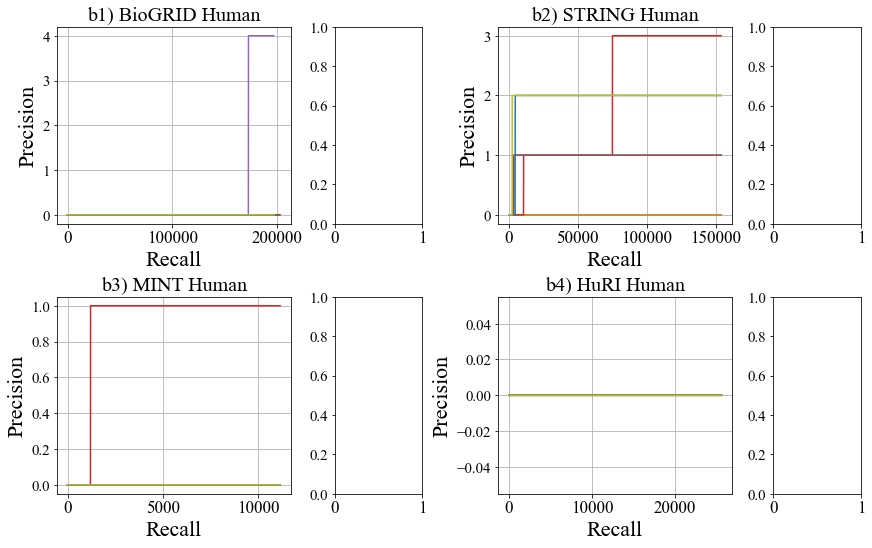

In [143]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

fig = plt.figure(constrained_layout=True, figsize=(12, 7.5))
widths = [4,1.5,4,1.5]
heights = [1,1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, 0]), fig.add_subplot(spec[0, 2]),
            fig.add_subplot(spec[1, 0]), fig.add_subplot(spec[1, 2])]
barAxes = [fig.add_subplot(spec[0, 1]), fig.add_subplot(spec[0, 3]),
           fig.add_subplot(spec[1, 1]), fig.add_subplot(spec[1, 3])]


randSz = 50
# lineAxes
dss = ['bioGRID_human', 'STRING_human', 'MINT_human', 'HuRI']
dsNames = ['BioGRID', 'STRING', 'MINT', 'HuRI']
for i in range(len(dss)):
    ds = dss[i]
    print(ds)
    ax = lineAxes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
        ax.plot([i for i in range(len(fullNegPPI_hits[methods_names_inv[method]][ds][0]))]
                , fullNegPPI_hits[methods_names_inv[method]][ds][0]
                , color=colors[method], label=method)

    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    ax.grid()
    ax.set_title("b{}) {} Human".format(i+1, dsNames[i]))
    
plt.show()